#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

In [ ]:
!pip install koreanize_matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 42.2 MB/s eta 0:00:00


### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
# 주어진 데이터 셋을 불러오세요.
train_df = pd.read_csv(path + "data01_train.csv")
test_df = pd.read_csv(path + "data01_test.csv")
features_df = pd.read_csv(path + "features.csv")

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_df = train_df.drop('subject', axis=1)
test_df = test_df.drop('subject', axis=1)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
# 전체 데이터의 행, 열 개수를 확인
print("train 데이터 :", train_df.shape)
print("test 데이터 :", test_df.shape)
print("features 데이터 :", features_df.shape)

train 데이터 : (5881, 562)
test 데이터 : (1471, 562)
features 데이터 : (561, 4)


In [ ]:
# 전체 데이터의 상위 5개 행 확인
print("train 데이터 head:")
display(train_df.head())

print("test 데이터 head:")
display(test_df.head())

print("features 데이터 head:")
display(features_df.head())

train 데이터 head:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


test 데이터 head:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


features 데이터 head:


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [ ]:
# 전체 데이터의 수치형 변수 분포 확인
print("train 데이터 describe:")
display(train_df.describe())

print("train 데이터 describe:")
display(test_df.describe())

train 데이터 describe:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


train 데이터 describe:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


In [ ]:
#전체 데이터의 모든 변수 확인
print(train_df.columns)
print('')
print(test_df.columns)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),grav

In [ ]:
#(추가) 다양하게 기본 정보들을 확인하세요!
print(train_df.info())
print('')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB
None


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)
print('범주별 빈도수 : ')
activity_counts = train_df['Activity'].value_counts()
activity_counts

범주별 빈도수 : 


,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [ ]:
print('범주별 비율 : ')
activity_ratio =train_df['Activity'].value_counts(normalize=True)
activity_ratio

범주별 비율 : 


,proportion
Activity,
LAYING,0.189594
STANDING,0.184833
SITTING,0.175480
WALKING,0.169699
WALKING_UPSTAIRS,0.145894
WALKING_DOWNSTAIRS,0.134501


In [ ]:
activity_unique = train_df['Activity'].unique()
print("Activity 종류:", activity_unique)

Activity 종류: ['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']


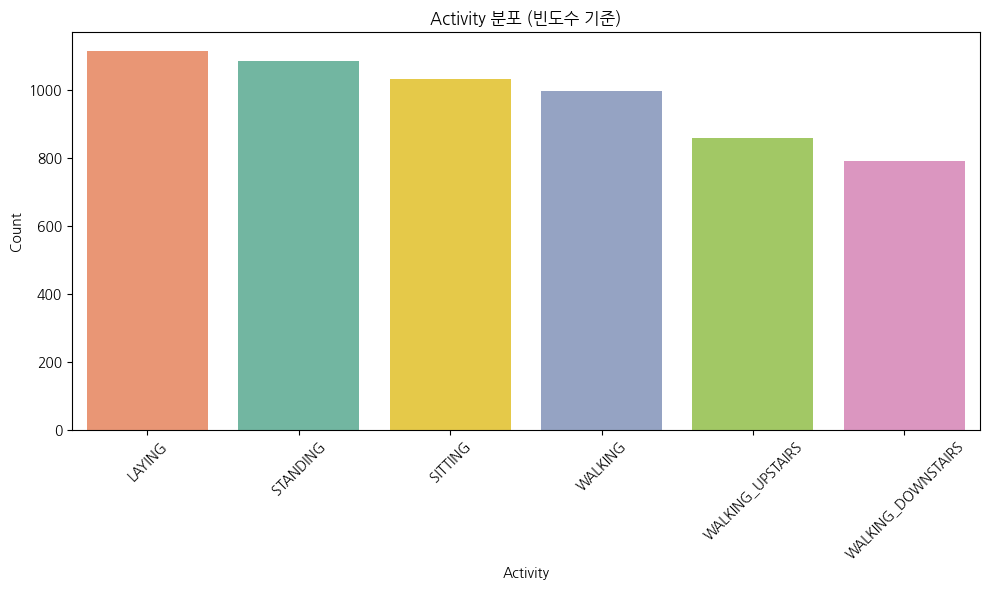

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Activity', data=train_df, hue='Activity', order=activity_counts.index, palette='Set2', legend=False)
plt.title("Activity 분포 (빈도수 기준)")
plt.ylabel("Count")
plt.xlabel("Activity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
features_df['sensor'].value_counts()

,count
sensor,
fBodyGyro,79
fBodyAccJerk,79
fBodyAcc,79
tBodyAcc,40
tGravityAcc,40
tBodyAccJerk,40
tBodyGyroJerk,40
tBodyGyro,40
tGravityAccMag,13


In [ ]:
#센서 그룹 데이터의 'agg'변수의 값 확인
features_df['agg'].value_counts()

,count
agg,
bandsEnergy(),126
arCoeff(),60
std(),33
mad(),33
max(),33
energy(),33
min(),33
entropy(),33
iqr(),33


In [ ]:
#센서 그룹 데이터의 'axis'변수의 값 확인
features_df['axis'].value_counts()

,count
axis,
X,76
Y,76
Z,76
gravityMean,6
"X,2",5
...,...
"17,32.2",2
"49,64.2",2
"1,24.2",2


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
# 데이터 분할을 위한 전처리
from sklearn.model_selection import train_test_split

target = 'Activity'
x = train_df.drop(target, axis=1)
y = train_df[target]

# train/validation 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

#### 2) 모델링

In [ ]:
from sklearn.metrics import accuracy_score,classification_report
#생성
rf_model=RandomForestClassifier(random_state=42)

#학습
rf_model.fit(x_train, y_train)

y_pred=rf_model.predict(x_val)

#평가
print("정확도 : ", accuracy_score(y_val, y_pred))
print("분류 보고서 : \n ",classification_report(y_val, y_pred))

정확도 :  0.973371104815864
분류 보고서 : 
                      precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       334
           SITTING       0.96      0.97      0.96       310
          STANDING       0.97      0.96      0.96       313
           WALKING       0.98      0.98      0.98       292
WALKING_DOWNSTAIRS       0.96      0.96      0.96       239
  WALKING_UPSTAIRS       0.97      0.97      0.97       277

          accuracy                           0.97      1765
         macro avg       0.97      0.97      0.97      1765
      weighted avg       0.97      0.97      0.97      1765



#### 3) 변수 중요도 추출

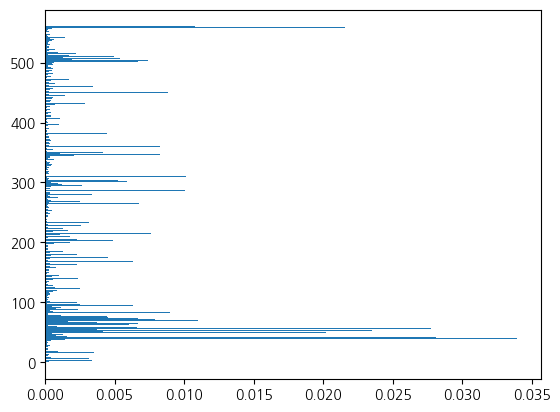

In [ ]:
# 변수 중요도 추출(시각화로 나타내기)
plt.barh(list(range(x.shape[1])), rf_model.feature_importances_)
plt.show()

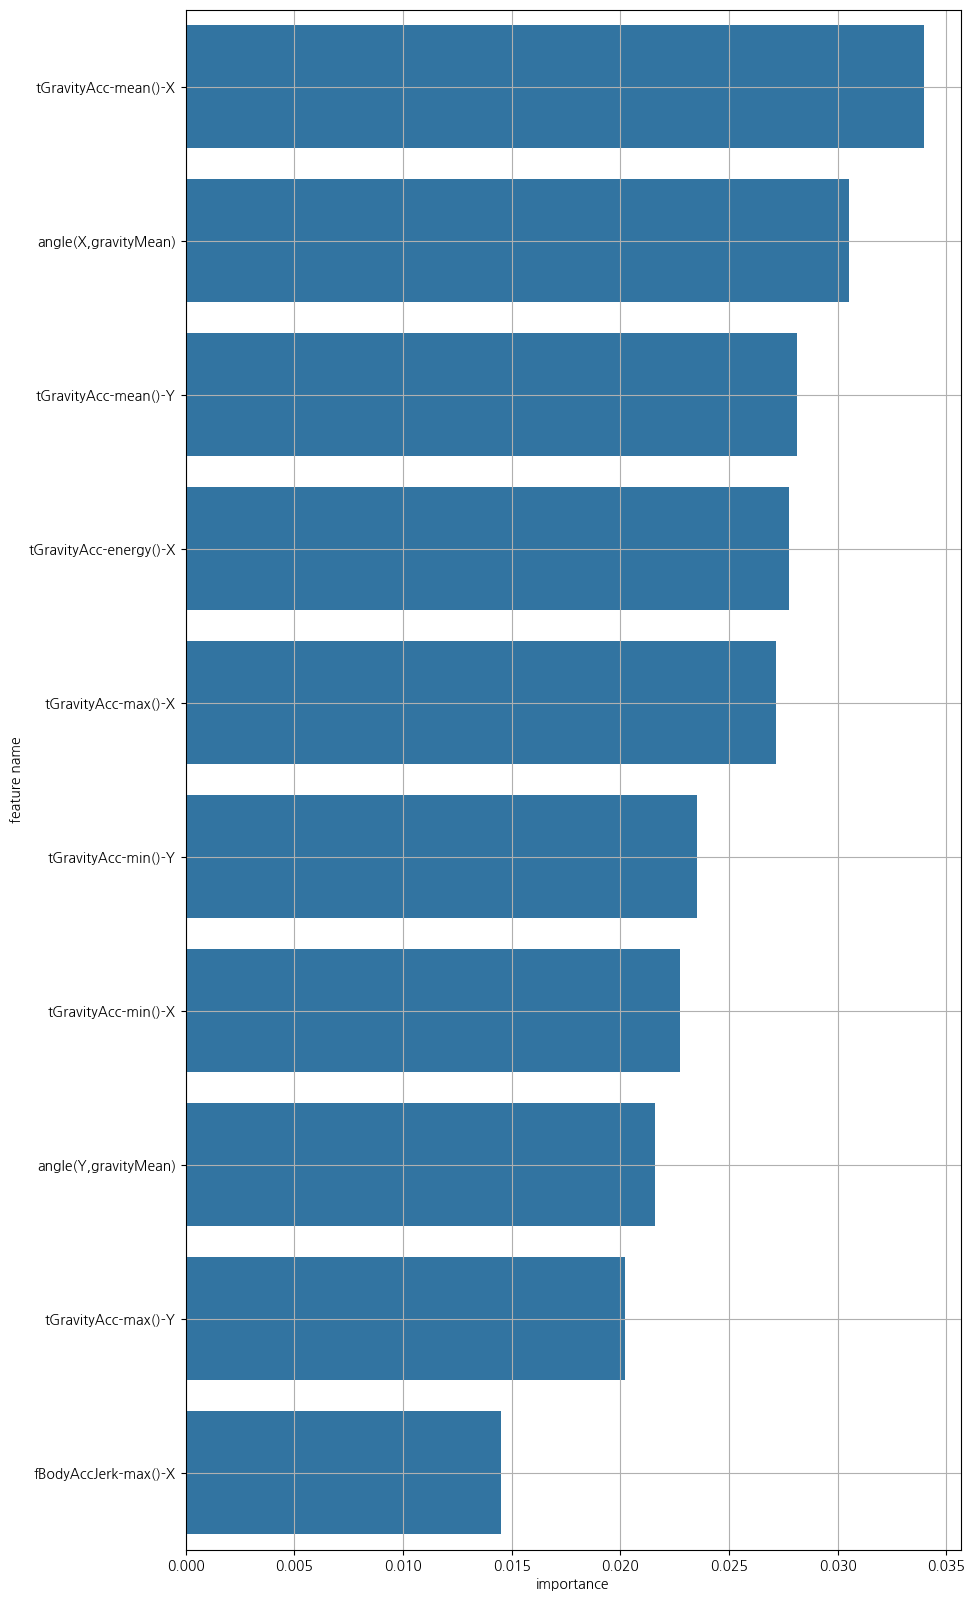

In [ ]:
importance = rf_model.feature_importances_  # 모델에서 얻은 변수 중요도
feature_names = x_train.columns  # 학습 데이터의 피처 이름

#  중요도 시각화 (상위 10개)
fi_df_importance = plot_feature_importance(importance, feature_names, topn=10)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 중요도 상위 top 5

top5_features = fi_df_importance.head(5)
top5_features

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.033954
1,"angle(X,gravityMean)",0.030501
2,tGravityAcc-mean()-Y,0.028108
3,tGravityAcc-energy()-X,0.027765
4,tGravityAcc-max()-X,0.027145


In [ ]:
# 중요도 하위 top 5
bottom5_features = fi_df_importance.tail(5)

# 인덱스 재설정
bottom5_features = bottom5_features.reset_index(drop=True)[::-1]
bottom5_features

,feature_name,importance_activity
4,fBodyAccJerk-max()-X,0.014489
3,tGravityAcc-max()-Y,0.020231
2,"angle(Y,gravityMean)",0.021600
1,tGravityAcc-min()-X,0.022749
0,tGravityAcc-min()-Y,0.023528


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

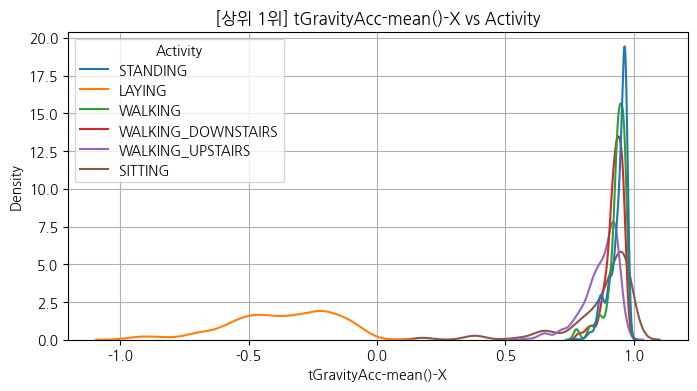

In [ ]:
#1위 : tGravityAcc-mean()-X
feature = top5_features['feature_name'][0]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[상위 1위] {feature} vs Activity")
plt.grid()
plt.show()

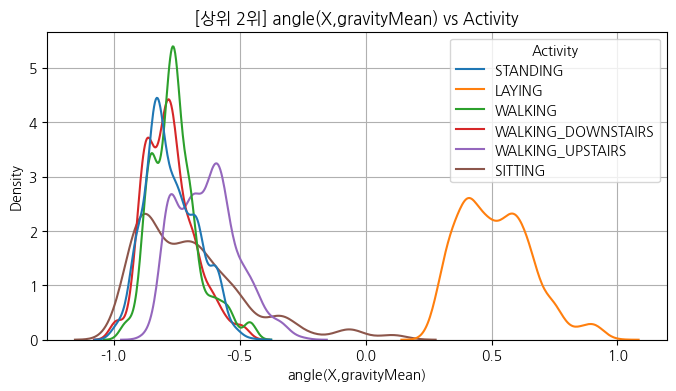

In [ ]:
#2위: angle(X,gravityMean)
feature = top5_features['feature_name'][1]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[상위 2위] {feature} vs Activity")
plt.grid()
plt.show()

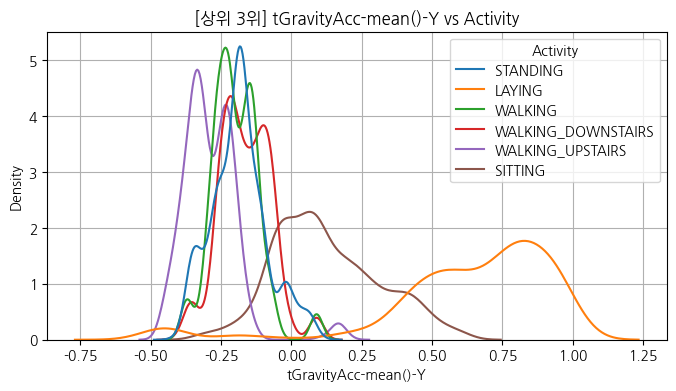

In [ ]:
feature = top5_features['feature_name'][2]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[상위 3위] {feature} vs Activity")
plt.grid()
plt.show()

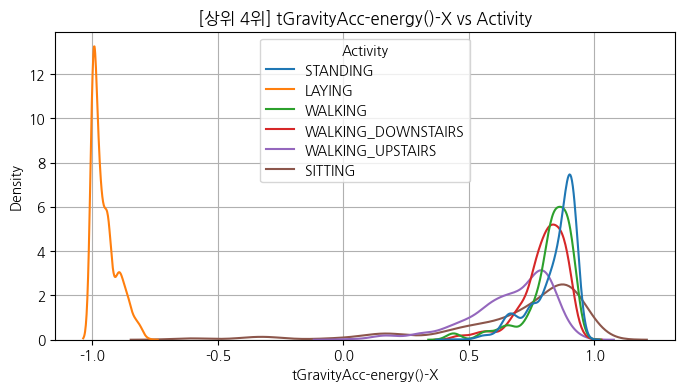

In [ ]:
feature = top5_features['feature_name'][3]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[상위 4위] {feature} vs Activity")
plt.grid()
plt.show()

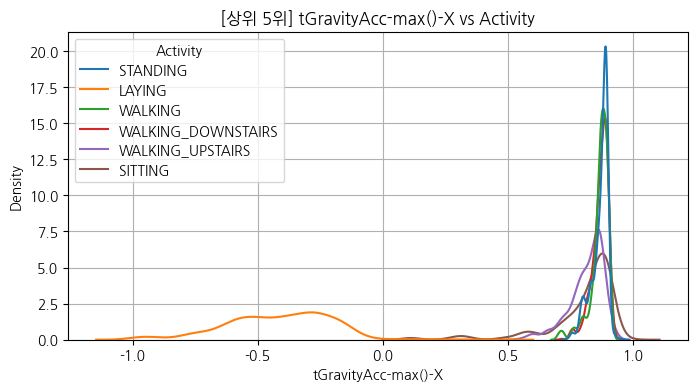

In [ ]:
feature = top5_features['feature_name'][4]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[상위 5위] {feature} vs Activity")
plt.grid()
plt.show()

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

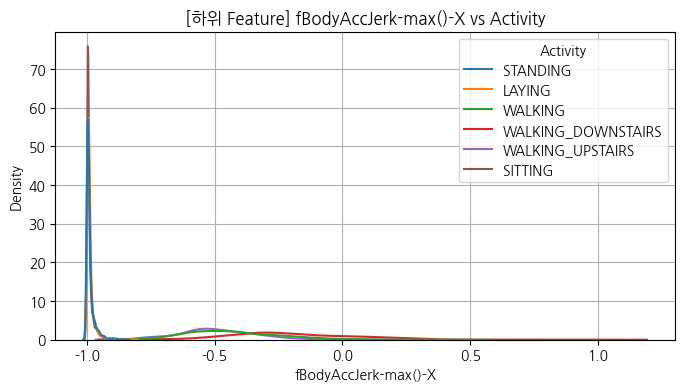

In [ ]:
#1위 :tGravityAcc-max()-Y
feature = bottom5_features['feature_name'][4]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[하위 Feature] {feature} vs Activity")
plt.grid()
plt.show()

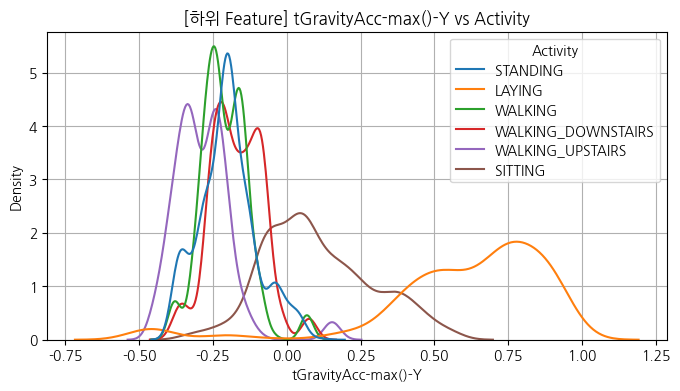

In [ ]:
#2위: fBodyAccJerk-max()-X
feature = bottom5_features['feature_name'][3]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[하위 Feature] {feature} vs Activity")
plt.grid()
plt.show()

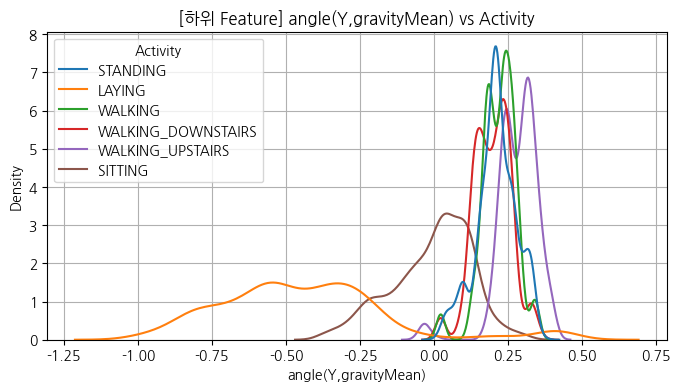

In [ ]:
feature = bottom5_features['feature_name'][2]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[하위 Feature] {feature} vs Activity")
plt.grid()
plt.show()

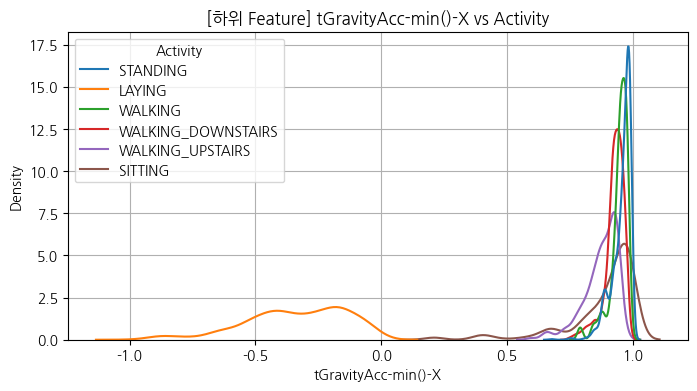

In [ ]:
feature = bottom5_features['feature_name'][1]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[하위 Feature] {feature} vs Activity")
plt.grid()
plt.show()

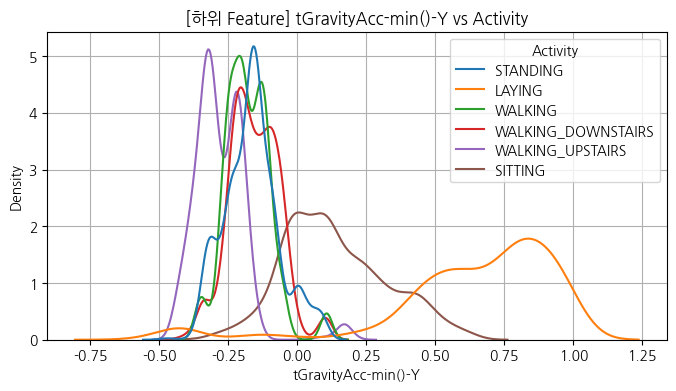

In [ ]:
feature = bottom5_features['feature_name'][0]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=train_df, x=feature, hue='Activity', common_norm=False)
plt.title(f"[하위 Feature] {feature} vs Activity")
plt.grid()
plt.show()

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [ ]:
#정적, 동적 활동에 해당하는 행동 리스트
static_activities = ["STANDING", "SITTING", "LAYING"]
dynamic_activities = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]

# is_dynamic 변수 추가: 정적이면 0, 동적이면 1
train_df['is_dynamic'] = train_df['Activity'].apply(lambda x: 0 if x in static_activities else 1)

# 추가된 변수의 값 확인
print("is_dynamic 변수 값 분포:")
print(train_df['is_dynamic'].value_counts())

is_dynamic 변수 값 분포:
is_dynamic
0    3234
1    2647
Name: count, dtype: int64


#### 2) 기본모델 생성

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
from sklearn.model_selection import train_test_split

x = train_df.drop(['Activity','is_dynamic'], axis=1)
y = train_df['is_dynamic']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
#RandomForestClassifier로 모델링 진행
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 모델 생성
rf_model1 = RandomForestClassifier(random_state=42)

# 모델 학습
rf_model1.fit(x_train, y_train)

# 예측 및 평가
y_pred1 = rf_model1.predict(x_val)

print("정확도 :", accuracy_score(y_val, y_pred1))
print("\n[분류 보고서]\n", classification_report(y_val, y_pred1))

정확도 : 1.0

[분류 보고서]
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 3) 변수중요도 상위 5개 분석

In [ ]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
fi_df_dynamic = plot_feature_importance(
    importance=rf_model1.feature_importances_,
    names=x_train.columns,
    result_only=True,
    topn='all'
)

# 상위 5개만 추출
fi_df = fi_df_dynamic.head(5)

# 결과 출력
print("is_dynamic 예측에 중요한 상위 5개 feature")
display(fi_df)

is_dynamic 예측에 중요한 상위 5개 feature


,feature_name,feature_importance
0,tBodyGyroJerk-iqr()-Z,0.069799
1,fBodyAccJerk-max()-X,0.060114
2,"fBodyAccJerk-bandsEnergy()-1,16",0.050009
3,tBodyAccJerk-std()-X,0.049965
4,tBodyAccJerk-iqr()-X,0.040047


* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

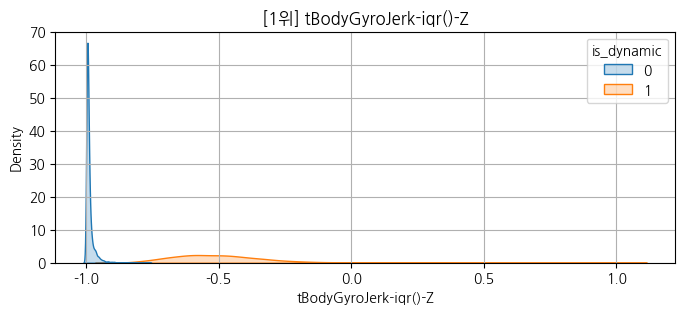

In [ ]:
#1위:tBodyGyroJerk-iqr()-Z
feature = fi_df['feature_name'][0]
plt.figure(figsize=(8, 3))
sns.kdeplot(data=train_df, x=feature, hue='is_dynamic', common_norm=False,fill=True)
plt.title(f"[1위] {feature}")
plt.grid()
plt.show()

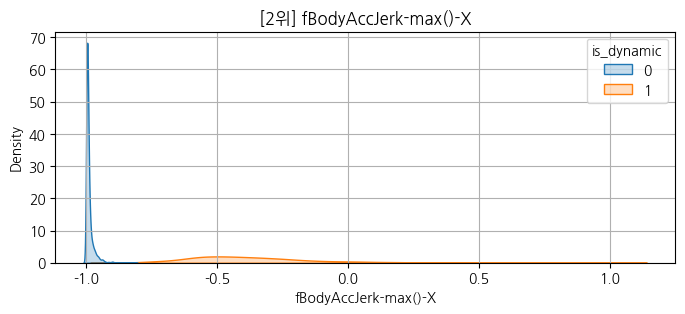

In [ ]:
#2위:fBodyAccJerk-max()-X
feature = fi_df['feature_name'][1]
plt.figure(figsize=(8, 3))
sns.kdeplot(data=train_df, x=feature, hue='is_dynamic', common_norm=False,fill=True)
plt.title(f"[2위] {feature}")
plt.grid()
plt.show()

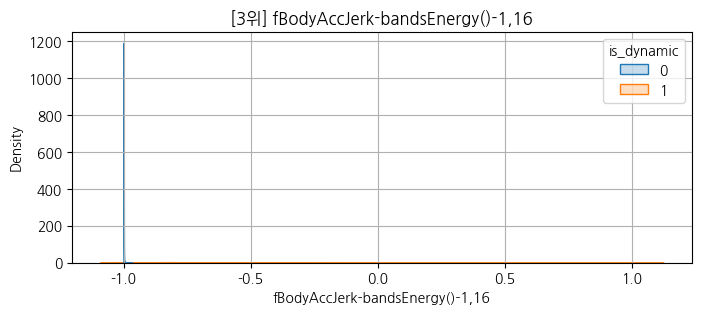

In [ ]:
feature = fi_df['feature_name'][2]
plt.figure(figsize=(8, 3))
sns.kdeplot(data=train_df, x=feature, hue='is_dynamic', common_norm=False,fill=True)
plt.title(f"[3위] {feature}")
plt.grid()
plt.show()

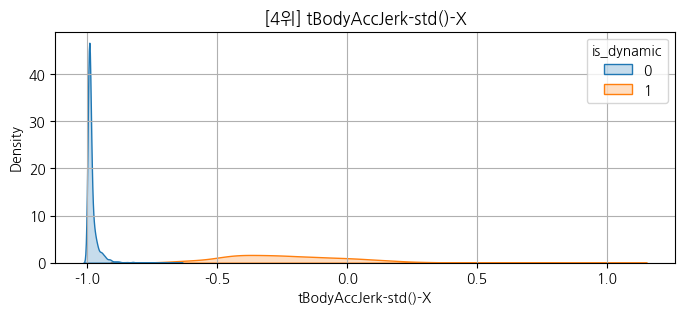

In [ ]:
feature = fi_df['feature_name'][3]
plt.figure(figsize=(8, 3))
sns.kdeplot(data=train_df, x=feature, hue='is_dynamic', common_norm=False,fill=True)
plt.title(f"[4위] {feature}")
plt.grid()
plt.show()

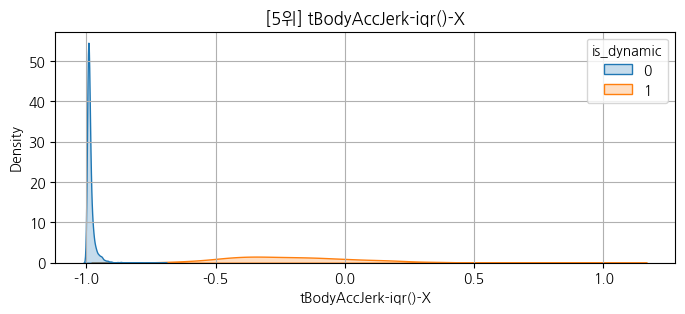

In [ ]:
feature = fi_df['feature_name'][4]
plt.figure(figsize=(8, 3))
sns.kdeplot(data=train_df, x=feature, hue='is_dynamic', common_norm=False,fill=True)
plt.title(f"[5위] {feature}")
plt.grid()
plt.show()

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
# 6개 행동 구분 중요도 결과 -> 컬럼 이름 변경
fi_df_importance = fi_df_importance.rename(columns={'feature_importance': 'importance_activity'})

# is_dynamic 구분 중요도 결과 -> 컬럼 이름 변경
fi_df_dynamic = fi_df_dynamic.rename(columns={'feature_importance': 'importance_dynamic'})

#### 2) 합치기

In [ ]:
# merge 해서 2개를 합치는 작업하기

# 기준이 되는 features.csv 불러오기
features = pd.read_csv(path + '/features.csv')  # 경로는 본인 상황에 맞게 수정

merged_importance = pd.merge(fi_df_importance, fi_df_dynamic, on='feature_name', how='outer')

# 결과 확인
print("병합된 DataFrame 미리 보기:")
print(merged_importance.head())

병합된 DataFrame 미리 보기:
                           feature_name  importance_activity  \
0                  angle(X,gravityMean)             0.030501   
1                  angle(Y,gravityMean)             0.021600   
2                  angle(Z,gravityMean)                  NaN   
3  angle(tBodyAccJerkMean),gravityMean)                  NaN   
4           angle(tBodyAccMean,gravity)                  NaN   

   importance_dynamic  
0            0.000161  
1            0.000068  
2            0.000023  
3            0.000000  
4            0.000000  


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
save_path = path + 'feature_importance_merged.pkl'
# joblib로 저장
joblib.dump(merged_importance, save_path)

print(f"✅ 저장 완료: {save_path}")

✅ 저장 완료: /content/drive/MyDrive/project3/feature_importance_merged.pkl


#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.